In [18]:
# Base
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Hypothesis Testing
from scipy import stats
from scipy.stats import shapiro

# Configuration
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('display.max_columns', None)  # 모든 열을 출력할 수 있도록 설정
pd.options.display.float_format = '{:.4f}'.format

In [ ]:
# A/B Testing Process¶
# --now-> 1. Understanding business problem & data
# 2. Detect and resolve problems in the data (Missing Value, Outliers, Unexpected Value)
# 3. Look summary stats and plots
# 4. Apply hypothesis testing and check assumptions
#   - Check Normality & Homogeneity
#   - Apply tests (Shapiro, Levene Test, T-Test, Welch Test, Mann Whitney U Test)
# 5. Evaluate the results
# 6. Make inferences
# 7. Recommend business decision to your customer/director/ceo etc.

In [ ]:
# Data columns (total 5 columns):
#  #   Column          Non-Null Count  Dtype 
# ---  ------          --------------  ----- 
#  0   userid          90189 non-null  int64 
#  1   version         90189 non-null  object
#  2   sum_gamerounds  90189 non-null  int64 
#  3   retention_1     90189 non-null  bool  
#  4   retention_7     90189 non-null  bool

# - retention은 특정 기간이 지난 후, 사용자가 얼마나 다시 돌아와 서비스를 이용하는지를 의미.
# - retention rate(유지율) = (N일 후 돌아온 사용자 수 ÷ N일 전에 서비스를 이용한 사용자 수) × 100
# - retention_1 : 1일 후에도 접속했는지 T/F
# - retention_7 : 7일 후에도 접속했는지 T/F
# - sum_gamerounds : 사용자가 첫 14일간 플레이한 게임 라운드 수 
# - version : 사용자가 플레이한 버전 (gate_30 : 통제그룹, 30레벨의 게이트, gate_40 : 실험그룹, 40레벨의 게이트)

In [27]:
def load_data(data_filepath: str, info: bool = False):    
    data = pd.read_csv(data_filepath)
    if info:
        print("# [INFO] Data Columns")
        print(data.info())
    return data

data = load_data("datasets/cookie_cats.csv", info=False)

In [ ]:
# A/B Testing Process¶
# 1. Understanding business problem & data
# --now-> 2. Detect and resolve problems in the data (Missing Value, Outliers, Unexpected Value)
# --now-> 3. Look summary stats and plots
# 4. Apply hypothesis testing and check assumptions
#   - Check Normality & Homogeneity
#   - Apply tests (Shapiro, Levene Test, T-Test, Welch Test, Mann Whitney U Test)
# 5. Evaluate the results
# 6. Make inferences
# 7. Recommend business decision to your customer/director/ceo etc.

In [28]:
def check_missing_values(data: pd.DataFrame, info: bool = False):
    result_series = data.isna().sum()
    result = all(result_series == 0)
    if info:
        if result:
            print("# [INFO] There is no missing value in the dataset.")
        else:
            print("# [INFO] There are missing values in the dataset.")
            print(result_series)
    return result

_ = check_missing_values(data, info=False)

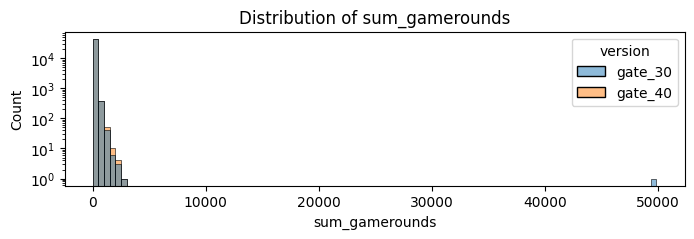

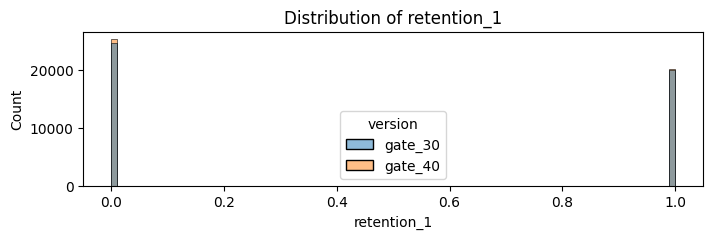

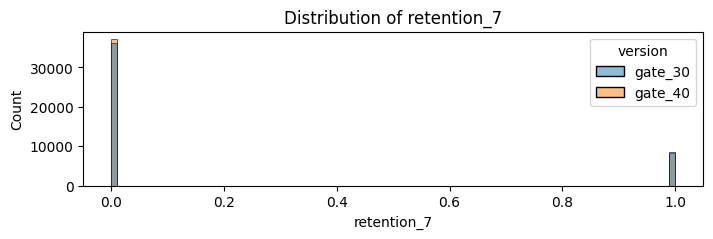

In [57]:
def display_distribution(data: pd.DataFrame, column: str, log_scale: bool = False):
    plt.figure(figsize=(8, 2))
    sns.histplot(data, x=column, hue='version', bins=100, kde=False)
    plt.yscale("log") if log_scale else None
    plt.title(f"Distribution of {column}")
    plt.show()

display_distribution(data, "sum_gamerounds", log_scale=True)    # found outliers!
display_distribution(data, "retention_1")
display_distribution(data, "retention_7")

# [INFO] Outliers
Lower Bound: 0.0, Upper Bound: 493.0
# of original data: 90189
# of general data: 89291
# of upper data: 898
# of lower data: 0


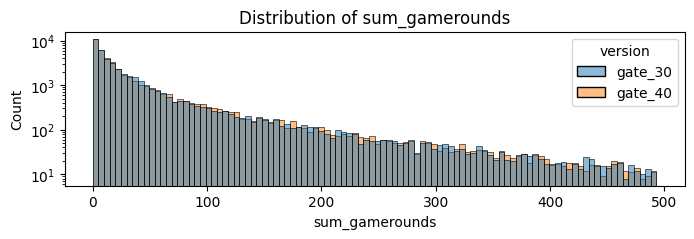

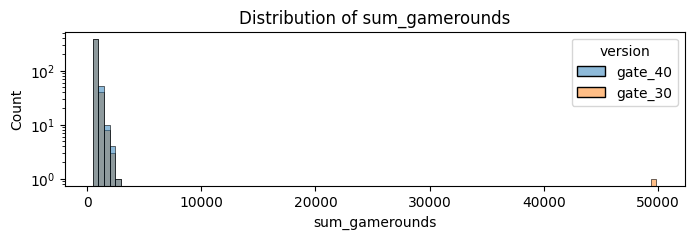

In [82]:
ourtliers = data[data["sum_gamerounds"] > 2000]
data['sum_gamerounds'].describe()
data['sum_gamerounds'].quantile(0.99)

def extract_outliers(data: pd.DataFrame, column: str, threshold: float, info: bool = False):
    lower_bound = data[column].quantile(threshold)
    upper_bound = data[column].quantile(1 - threshold)
    general_data = data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]
    upper_data = data[data[column] > upper_bound]
    lower_data = data[data[column] < lower_bound]
    if info:
        print("# [INFO] Outliers")
        print(f"Lower Bound: {lower_bound}, Upper Bound: {upper_bound}")
        print(f"# of original data: {len(data)}")
        print(f"# of general data: {len(general_data)}")
        print(f"# of upper data: {len(upper_data)}")
        print(f"# of lower data: {len(lower_data)}")
    return general_data, upper_data, lower_data

general_data, upper_data, lower_data = extract_outliers(data, "sum_gamerounds", 0.01, info=True)
display_distribution(general_data, "sum_gamerounds", log_scale=True)
display_distribution(upper_data, "sum_gamerounds", log_scale=True)

In [83]:
def get_stats(data: pd.DataFrame, info_keys: list = []):
    results = {}
    results['count'] = data.groupby('version').count() # gate_30 : 44700, gate_40 : 45489 
    results['mean'] = data.groupby('version')[['sum_gamerounds', 'retention_1', 'retention_7']].mean()
    results['median'] = data.groupby('version')[['sum_gamerounds', 'retention_1', 'retention_7']].median()
    for key in info_keys:
        print("# [INFO] Summary Statistics:", key)
        display(results[key])
    return results
# _ = get_stats(data, info_keys=['count', 'mean', 'median'])
_ = get_stats(general_data, info_keys=['count', 'mean', 'median'])
_ = get_stats(upper_data, info_keys=['count', 'mean', 'median'])

# [INFO] Summary Statistics: count


,userid,sum_gamerounds,retention_1,retention_7
version,,,,
gate_30,44254,44254,44254,44254
gate_40,45037,45037,45037,45037


# [INFO] Summary Statistics: mean


,sum_gamerounds,retention_1,retention_7
version,,,
gate_30,44.6625,0.4429,0.1825
gate_40,44.3964,0.4369,0.1742


# [INFO] Summary Statistics: median


,sum_gamerounds,retention_1,retention_7
version,,,
gate_30,16.0000,0.0000,0.0000
gate_40,16.0000,0.0000,0.0000


# [INFO] Summary Statistics: count


,userid,sum_gamerounds,retention_1,retention_7
version,,,,
gate_30,446,446,446,446
gate_40,452,452,452,452


# [INFO] Summary Statistics: mean


,sum_gamerounds,retention_1,retention_7
version,,,
gate_30,825.7870,0.9709,0.9507
gate_40,739.0487,0.9779,0.9602


# [INFO] Summary Statistics: median


,sum_gamerounds,retention_1,retention_7
version,,,
gate_30,615.0000,1.0000,1.0000
gate_40,635.5000,1.0000,1.0000


최상위 1%내에서도 진짜 상위 몇 명이 아니면 난이도가 높을 때 게임 플레이 횟수가 많다. 그러나, 이상치로 분류될만큼 많이 한 케이스는 더 낮은 난이도에서 발생했다.

retention ratio에 초점을 맞춰 보면 일반적인 유저 집단에선 낮은 난이도에서 높은 점수가 나오지만, 상위 1% 집단에선 그 관계가 역전된다.

목표로 하는 대상이 누구인가(e.g. 돈을 많이 쓰는 대상, 상위 1%, 대중성)를 결정하는 것이 중요하게 작용할 것

In [ ]:
# A/B Testing Process¶
# 1. Understanding business problem & data
# 2. Detect and resolve problems in the data (Missing Value, Outliers, Unexpected Value)
# 3. Look summary stats and plots
# --todo-> 4. Apply hypothesis testing and check assumptions
#   - Check Normality & Homogeneity
#   - Apply tests (Shapiro, Levene Test, T-Test, Welch Test, Mann Whitney U Test)
# 5. Evaluate the results
# 6. Make inferences
# 7. Recommend business decision to your customer/director/ceo etc.